# 05 - EDA y Modelado: Clasificación de Eventos Delictivos

## Descripción del Dataset

Dataset enriquecido **por evento delictivo individual**, con información de:
- **Temporalidad avanzada**: año, mes, día, trimestre, festivos, fines de semana
- **Demografía**: edad y género de la persona involucrada
- **Geoespacial**: municipio, área, densidad poblacional, centros poblados
- **Histórico**: conteo de delitos por tipo en cada municipio (one-hot)
- **Perfil del evento**: clasificación agresor/víctima

## Objetivo

Entrenar un modelo **Multi-Output** que prediga simultáneamente:
1. **Tipo de delito** más probable dado un contexto
2. **Perfil** asociado al evento (agresor/víctima)

## Preguntas que Responde

| Pregunta | Target |
|----------|--------|
| ¿Qué tipo de delito es más probable para un contexto específico? | `delito` |
| ¿El perfil agresor/víctima se puede predecir? | `perfil` |
| ¿Qué factores temporales/demográficos influyen en cada delito? | Feature Importance |

## Utilidad para el Reto

- **Tablero web**: Mostrar predicción de delito/perfil según filtros seleccionados
- **Chatbot**: Responder "¿Qué delito es más probable en este municipio en diciembre?"
- **Alertas**: Identificar combinaciones de alto riesgo


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', 50)
np.random.seed(42)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'classification_event_dataset.parquet'

In [2]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2}. {col}")
df.head()

Shape: (343861, 63)

Columnas (63):
   1. departamento
   2. municipio
   3. edad_persona
   4. armas_medios
   5. cantidad
   6. fecha
   7. genero
   8. anio
   9. delito
  10. codigo_municipio
  11. mes
  12. dia
  13. es_dia_semana
  14. es_fin_de_semana
  15. es_fin_mes
  16. es_festivo
  17. nombre_festivo
  18. es_dia_laboral
  19. origen
  20. codigo_departamento
  21. municipio_ctx
  22. area
  23. departamento_ctx
  24. Shape_Leng
  25. Shape_Area
  26. geometry
  27. n_centros_poblados
  28. total_delitos
  29. ABIGEATO
  30. AMENAZAS
  31. DELITOS SEXUALES
  32. EXTORSION
  33. HOMICIDIOS
  34. HURTOS
  35. LESIONES
  36. VIOLENCIA INTRAFAMILIAR
  37. femenino_adolescentes
  38. femenino_adultos
  39. femenino_menores
  40. masculino_adolescentes
  41. masculino_adultos
  42. masculino_menores
  43. poblacion_total
  44. poblacion_menores
  45. poblacion_adultos
  46. poblacion_adolescentes
  47. area_km2
  48. densidad_poblacional
  49. centros_por_km2
  50. proporcion_men

,departamento,municipio,edad_persona,armas_medios,cantidad,fecha,genero,anio,delito,codigo_municipio,mes,dia,es_dia_semana,es_fin_de_semana,es_fin_mes,es_festivo,nombre_festivo,es_dia_laboral,origen,codigo_departamento,municipio_ctx,area,departamento_ctx,Shape_Leng,Shape_Area,...,femenino_menores,masculino_adolescentes,masculino_adultos,masculino_menores,poblacion_total,poblacion_menores,poblacion_adultos,poblacion_adolescentes,area_km2,densidad_poblacional,centros_por_km2,proporcion_menores,proporcion_adultos,proporcion_adolescentes,fecha_ctx,trimestre,anio_mes,es_fin_ano,n_dias_semana,n_fines_de_semana,n_festivos,n_dias_laborales,mes_sin,mes_cos,perfil
0,SANTANDER,FLORIÁN,ADULTOS,NO REPORTADO,1,2010-01-05,MASCULINO,2010,ABIGEATO,68271,1,5,1,0,0,0,None,1,SCRAPING,68,FLORIÁN,176.599655,SANTANDER,0.892371,0.014419,...,982,372,5335,1079,12682,2061,9959,662,176.599655,71.812145,0.022650,0.162514,0.785286,0.052200,2010-01-01,1,2010-01,0,2,2,1,1,0.5,0.866025,MASCULINO_ADULTOS
1,SANTANDER,PUENTE NACIONAL,ADULTOS,NO REPORTADO,1,2010-01-06,MASCULINO,2010,ABIGEATO,68572,1,6,1,0,0,0,None,1,SCRAPING,68,PUENTE NACIONAL,251.678548,SANTANDER,0.755909,0.020549,...,1722,642,10725,1833,26902,3555,22030,1317,251.678548,106.890318,0.027813,0.132146,0.818898,0.048955,2010-01-01,1,2010-01,0,13,4,0,13,0.5,0.866025,MASCULINO_ADULTOS
2,SANTANDER,PUENTE NACIONAL,ADULTOS,ARMA DE FUEGO,1,2010-01-07,MASCULINO,2010,ABIGEATO,68572,1,7,1,0,0,0,None,1,SCRAPING,68,PUENTE NACIONAL,251.678548,SANTANDER,0.755909,0.020549,...,1722,642,10725,1833,26902,3555,22030,1317,251.678548,106.890318,0.027813,0.132146,0.818898,0.048955,2010-01-01,1,2010-01,0,13,4,0,13,0.5,0.866025,MASCULINO_ADULTOS
3,SANTANDER,BARRANCABERMEJA,ADULTOS,NO REPORTADO,1,2010-01-10,MASCULINO,2010,ABIGEATO,68081,1,10,0,1,0,0,None,0,SCRAPING,68,BARRANCABERMEJA,1326.838302,SANTANDER,2.735190,0.108591,...,25413,10056,151760,26622,382996,52035,311624,19337,1326.838302,288.653108,0.005276,0.135863,0.813648,0.050489,2010-01-01,1,2010-01,0,85,53,15,70,0.5,0.866025,MASCULINO_ADULTOS
4,SANTANDER,MOGOTES,ADULTOS,NO REPORTADO,1,2010-01-17,MASCULINO,2010,ABIGEATO,68464,1,17,0,1,0,0,None,0,SCRAPING,68,MOGOTES,483.970127,SANTANDER,1.104474,0.039550,...,1622,625,8816,1711,21826,3333,17294,1199,483.970127,45.097825,0.008265,0.152708,0.792358,0.054934,2010-01-01,1,2010-01,0,4,1,1,3,0.5,0.866025,MASCULINO_ADULTOS


In [3]:
# Info general
print("=" * 60)
print("INFO GENERAL")
print("=" * 60)
print(f"\nTotal eventos: {len(df):,}")
print(f"Período: {df['anio'].min()} - {df['anio'].max()}")
print(f"Municipios: {df['codigo_municipio'].nunique()}")
print(f"\nValores nulos por columna:")
nulls = df.isnull().sum()
print(nulls[nulls > 0])

INFO GENERAL

Total eventos: 343,861
Período: 2010 - 2025
Municipios: 87

Valores nulos por columna:
nombre_festivo    327424
dtype: int64


---
## 1. Análisis del Target: Delito y Perfil

DISTRIBUCIÓN DE DELITOS (TARGET 1)

Clases únicas: 8

Distribución:
  LESIONES: 122,348 (35.6%)
  HURTOS: 104,201 (30.3%)
  VIOLENCIA INTRAFAMILIAR: 55,049 (16.0%)
  AMENAZAS: 32,123 (9.3%)
  DELITOS SEXUALES: 16,561 (4.8%)
  HOMICIDIOS: 9,340 (2.7%)
  EXTORSION: 2,952 (0.9%)
  ABIGEATO: 1,287 (0.4%)


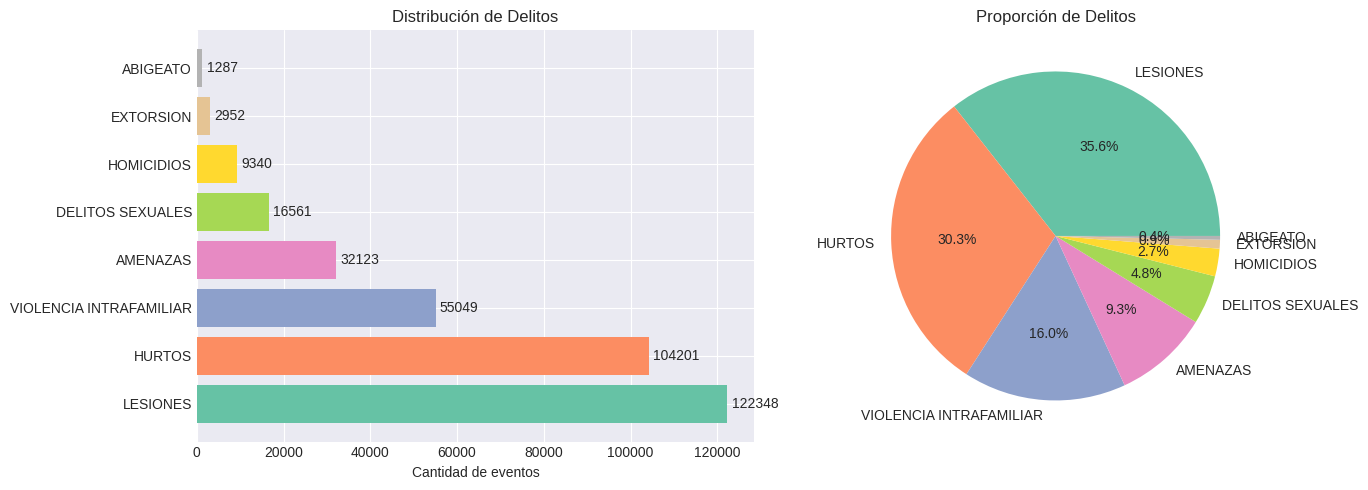


📊 Ratio de desbalance (max/min): 95.1x


In [4]:
# 1.1 Análisis de la variable target: DELITO
print("=" * 60)
print("DISTRIBUCIÓN DE DELITOS (TARGET 1)")
print("=" * 60)

delitos_dist = df['delito'].value_counts()
delitos_pct = (delitos_dist / len(df) * 100).round(2)

print(f"\nClases únicas: {df['delito'].nunique()}")
print(f"\nDistribución:")
for delito, count in delitos_dist.items():
    print(f"  {delito}: {count:,} ({delitos_pct[delito]:.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
colors = plt.cm.Set2(np.linspace(0, 1, len(delitos_dist)))
bars = ax1.barh(delitos_dist.index, delitos_dist.values, color=colors)
ax1.set_xlabel('Cantidad de eventos')
ax1.set_title('Distribución de Delitos')
ax1.bar_label(bars, fmt='%d', padding=3)

ax2 = axes[1]
ax2.pie(delitos_dist.values, labels=delitos_dist.index, autopct='%1.1f%%', colors=colors)
ax2.set_title('Proporción de Delitos')

plt.tight_layout()
plt.show()

# Análisis de desbalance
print(f"\n📊 Ratio de desbalance (max/min): {delitos_dist.max() / delitos_dist.min():.1f}x")

DISTRIBUCIÓN DE PERFILES (TARGET 2)

Clases únicas: 9

Distribución:
  MASCULINO_ADULTOS: 163,424 (47.5%)
  FEMENINO_ADULTOS: 143,049 (41.6%)
  FEMENINO_ADOLESCENTES: 12,086 (3.5%)
  MASCULINO_ADOLESCENTES: 11,221 (3.3%)
  FEMENINO_MENORES: 8,523 (2.5%)
  MASCULINO_MENORES: 5,429 (1.6%)
  NO REPORTA_ADULTOS: 124 (0.0%)
  NO REPORTA_MENORES: 4 (0.0%)
  NO REPORTA_ADOLESCENTES: 1 (0.0%)


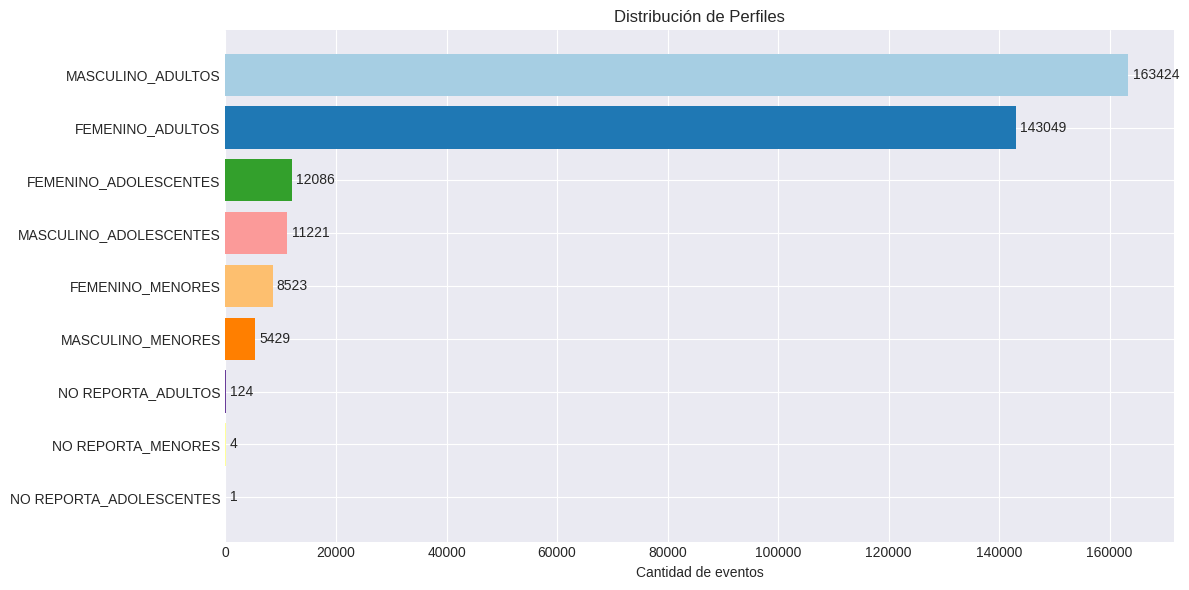


📊 Ratio de desbalance (max/min): 163424.0x


In [5]:
# 1.2 Análisis de la variable target: PERFIL
print("=" * 60)
print("DISTRIBUCIÓN DE PERFILES (TARGET 2)")
print("=" * 60)

perfil_dist = df['perfil'].value_counts()
perfil_pct = (perfil_dist / len(df) * 100).round(2)

print(f"\nClases únicas: {df['perfil'].nunique()}")
print(f"\nDistribución:")
for perfil, count in perfil_dist.items():
    print(f"  {perfil}: {count:,} ({perfil_pct[perfil]:.1f}%)")

# Visualización
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.Paired(np.linspace(0, 1, len(perfil_dist)))
bars = ax.barh(perfil_dist.index, perfil_dist.values, color=colors)
ax.set_xlabel('Cantidad de eventos')
ax.set_title('Distribución de Perfiles')
ax.bar_label(bars, fmt='%d', padding=3)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n📊 Ratio de desbalance (max/min): {perfil_dist.max() / perfil_dist.min():.1f}x")

RELACIÓN DELITO-PERFIL


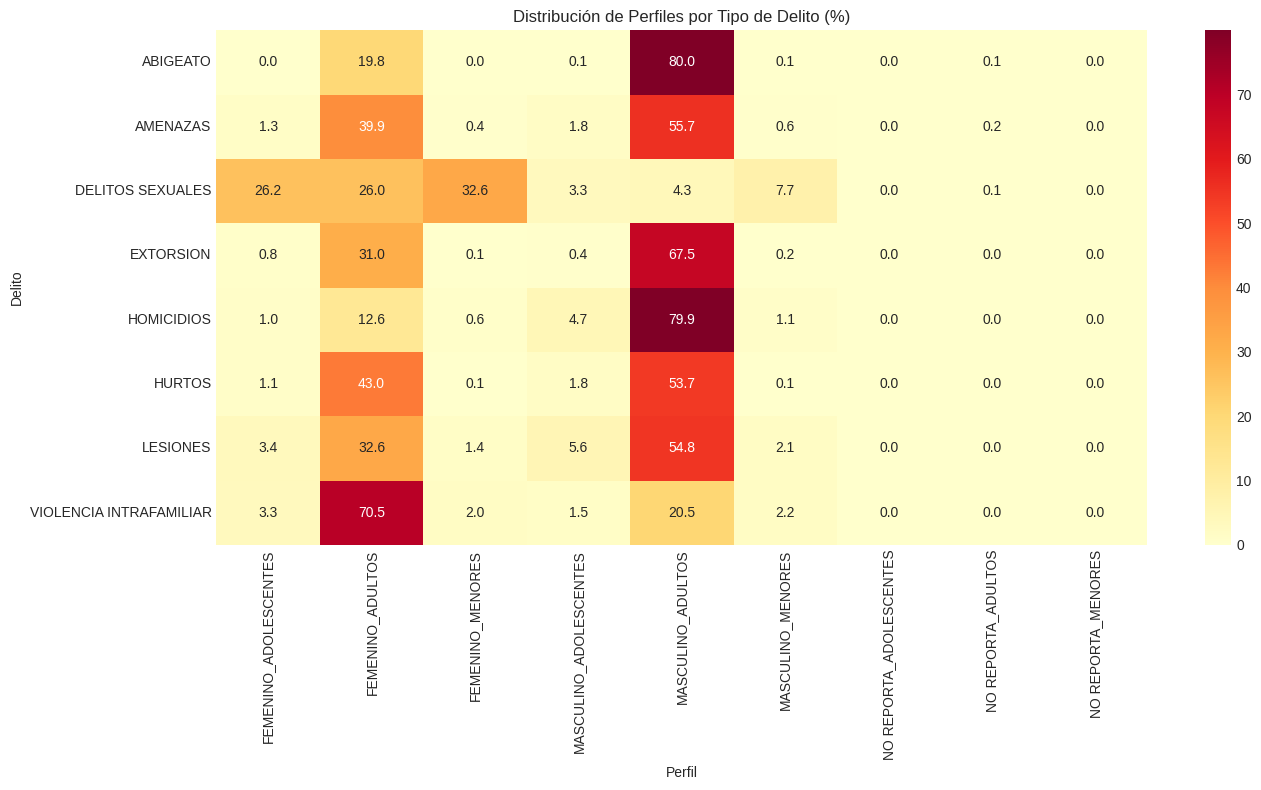


📊 Perfil más común por delito:
  ABIGEATO: MASCULINO_ADULTOS (80.0%)
  AMENAZAS: MASCULINO_ADULTOS (55.7%)
  DELITOS SEXUALES: FEMENINO_MENORES (32.6%)
  EXTORSION: MASCULINO_ADULTOS (67.5%)
  HOMICIDIOS: MASCULINO_ADULTOS (79.9%)
  HURTOS: MASCULINO_ADULTOS (53.7%)
  LESIONES: MASCULINO_ADULTOS (54.8%)
  VIOLENCIA INTRAFAMILIAR: FEMENINO_ADULTOS (70.5%)


In [6]:
# 1.3 Relación Delito-Perfil (Heatmap)
print("=" * 60)
print("RELACIÓN DELITO-PERFIL")
print("=" * 60)

# Crosstab
cross = pd.crosstab(df['delito'], df['perfil'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(cross, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax)
ax.set_title('Distribución de Perfiles por Tipo de Delito (%)')
ax.set_xlabel('Perfil')
ax.set_ylabel('Delito')
plt.tight_layout()
plt.show()

# Perfiles dominantes por delito
print("\n📊 Perfil más común por delito:")
for delito in cross.index:
    perfil_dom = cross.loc[delito].idxmax()
    pct = cross.loc[delito, perfil_dom]
    print(f"  {delito}: {perfil_dom} ({pct:.1f}%)")

---
## 2. Análisis de Features

In [7]:
# 2.1 Clasificar columnas por tipo
print("=" * 60)
print("CLASIFICACIÓN DE FEATURES")
print("=" * 60)

# Excluir columnas que no usaremos como features
cols_excluir = ['departamento', 'municipio', 'fecha', 'delito', 'perfil', 'geometry', 
                'nombre_festivo', 'origen', 'municipio_ctx', 'departamento_ctx', 
                'fecha_ctx', 'anio_mes']

# Categorizar features
features_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
features_numericas = [c for c in features_numericas if c not in cols_excluir]

features_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
features_categoricas = [c for c in features_categoricas if c not in cols_excluir]

features_binarias = [c for c in features_numericas if df[c].nunique() == 2]
features_continuas = [c for c in features_numericas if df[c].nunique() > 10]
features_discretas = [c for c in features_numericas if 2 < df[c].nunique() <= 10]

print(f"\n📊 Features numéricas: {len(features_numericas)}")
print(f"   - Binarias (0/1): {len(features_binarias)}")
print(f"   - Discretas: {len(features_discretas)}")
print(f"   - Continuas: {len(features_continuas)}")
print(f"\n📊 Features categóricas: {len(features_categoricas)}")
print(f"   {features_categoricas}")

print(f"\n🔹 Binarias: {features_binarias}")
print(f"\n🔹 Discretas: {features_discretas}")
print(f"\n🔹 Continuas: {features_continuas}")

CLASIFICACIÓN DE FEATURES

📊 Features numéricas: 47
   - Binarias (0/1): 6
   - Discretas: 2
   - Continuas: 39

📊 Features categóricas: 4
   ['edad_persona', 'armas_medios', 'genero', 'codigo_departamento']

🔹 Binarias: ['es_dia_semana', 'es_fin_de_semana', 'es_fin_mes', 'es_festivo', 'es_dia_laboral', 'es_fin_ano']

🔹 Discretas: ['ABIGEATO', 'trimestre']

🔹 Continuas: ['cantidad', 'anio', 'codigo_municipio', 'mes', 'dia', 'area', 'Shape_Leng', 'Shape_Area', 'n_centros_poblados', 'total_delitos', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 'HOMICIDIOS', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR', 'femenino_adolescentes', 'femenino_adultos', 'femenino_menores', 'masculino_adolescentes', 'masculino_adultos', 'masculino_menores', 'poblacion_total', 'poblacion_menores', 'poblacion_adultos', 'poblacion_adolescentes', 'area_km2', 'densidad_poblacional', 'centros_por_km2', 'proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes', 'n_dias_semana', 'n_fines_de_semana', 'n_fe

ANÁLISIS TEMPORAL


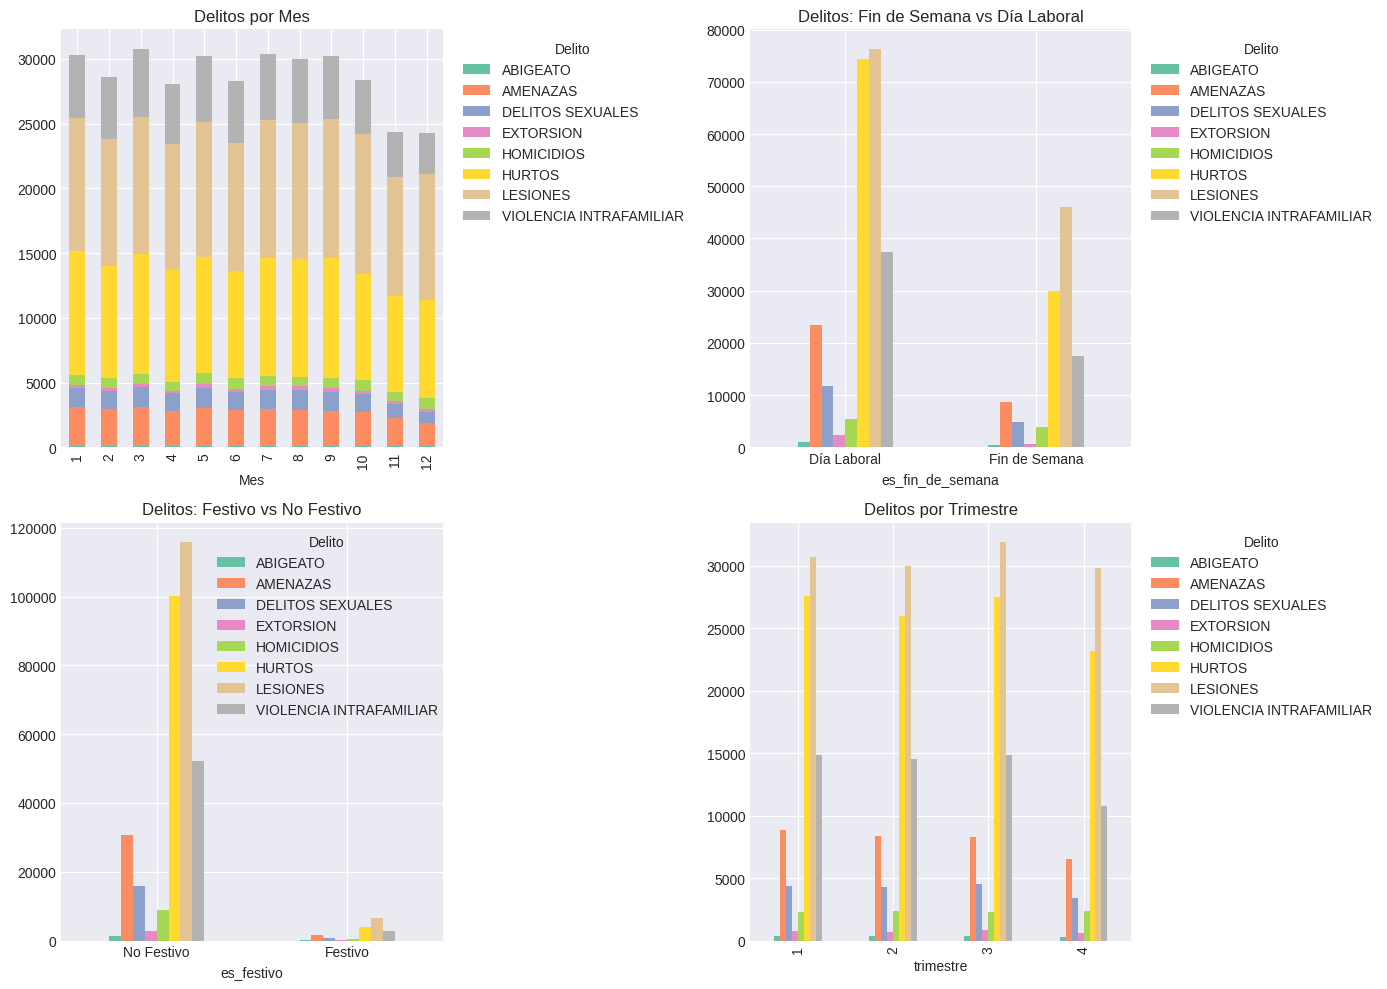

In [8]:
# 2.2 Análisis temporal: Delitos por variables temporales
print("=" * 60)
print("ANÁLISIS TEMPORAL")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Por mes
ax1 = axes[0, 0]
delito_mes = df.groupby(['mes', 'delito']).size().unstack(fill_value=0)
delito_mes.plot(kind='bar', stacked=True, ax=ax1, colormap='Set2')
ax1.set_title('Delitos por Mes')
ax1.set_xlabel('Mes')
ax1.legend(title='Delito', bbox_to_anchor=(1.02, 1))

# Fin de semana vs días laborales
ax2 = axes[0, 1]
fds_delito = df.groupby(['es_fin_de_semana', 'delito']).size().unstack(fill_value=0)
fds_delito.plot(kind='bar', ax=ax2, colormap='Set2')
ax2.set_title('Delitos: Fin de Semana vs Día Laboral')
ax2.set_xticklabels(['Día Laboral', 'Fin de Semana'], rotation=0)
ax2.legend(title='Delito', bbox_to_anchor=(1.02, 1))

# Festivos
ax3 = axes[1, 0]
fest_delito = df.groupby(['es_festivo', 'delito']).size().unstack(fill_value=0)
fest_delito.plot(kind='bar', ax=ax3, colormap='Set2')
ax3.set_title('Delitos: Festivo vs No Festivo')
ax3.set_xticklabels(['No Festivo', 'Festivo'], rotation=0)
ax3.legend(title='Delito', bbox_to_anchor=(1.02, 1))

# Por trimestre
ax4 = axes[1, 1]
trim_delito = df.groupby(['trimestre', 'delito']).size().unstack(fill_value=0)
trim_delito.plot(kind='bar', ax=ax4, colormap='Set2')
ax4.set_title('Delitos por Trimestre')
ax4.legend(title='Delito', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

ANÁLISIS DEMOGRÁFICO


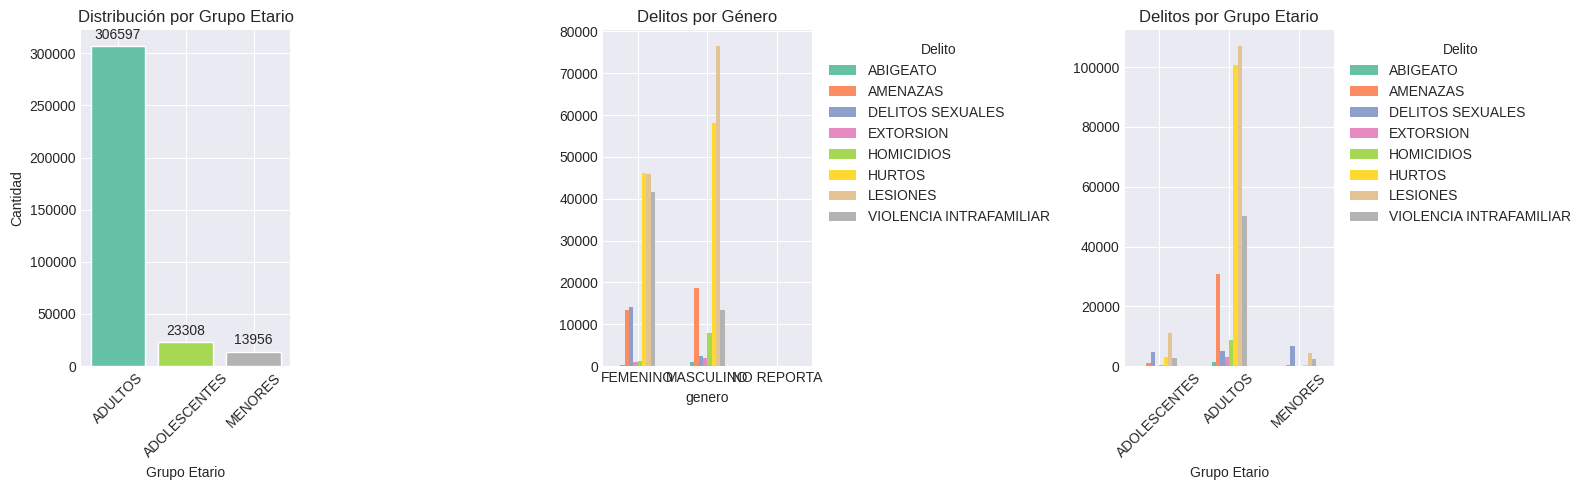


📊 Distribución de grupo etario por delito:
edad_persona             ADOLESCENTES  ADULTOS  MENORES     All
delito                                                         
ABIGEATO                            1     1285        1    1287
AMENAZAS                         1010    30790      323   32123
DELITOS SEXUALES                 4874     5026     6661   16561
EXTORSION                          35     2908        9    2952
HOMICIDIOS                        538     8637      165    9340
HURTOS                           3120   100849      232  104201
LESIONES                        11086   106965     4297  122348
VIOLENCIA INTRAFAMILIAR          2644    50137     2268   55049
All                             23308   306597    13956  343861


In [9]:
# 2.3 Análisis demográfico: Edad y Género
print("=" * 60)
print("ANÁLISIS DEMOGRÁFICO")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Distribución de grupo etario (edad_persona es categórica)
ax1 = axes[0]
edad_dist = df['edad_persona'].value_counts()
colors = plt.cm.Set2(np.linspace(0, 1, len(edad_dist)))
bars = ax1.bar(edad_dist.index.astype(str), edad_dist.values, color=colors, edgecolor='white')
ax1.set_title('Distribución por Grupo Etario')
ax1.set_xlabel('Grupo Etario')
ax1.set_ylabel('Cantidad')
ax1.bar_label(bars, fmt='%d', padding=3)
ax1.tick_params(axis='x', rotation=45)

# Delitos por género
ax2 = axes[1]
genero_delito = df.groupby(['genero', 'delito']).size().unstack(fill_value=0)
genero_delito.plot(kind='bar', ax=ax2, colormap='Set2')
ax2.set_title('Delitos por Género')
ax2.legend(title='Delito', bbox_to_anchor=(1.02, 1))
ax2.tick_params(axis='x', rotation=0)

# Delitos por grupo etario (en lugar de boxplot numérico)
ax3 = axes[2]
edad_delito = df.groupby(['edad_persona', 'delito']).size().unstack(fill_value=0)
edad_delito.plot(kind='bar', ax=ax3, colormap='Set2')
ax3.set_title('Delitos por Grupo Etario')
ax3.set_xlabel('Grupo Etario')
ax3.legend(title='Delito', bbox_to_anchor=(1.02, 1))
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Estadísticas de grupo etario por delito
print("\n📊 Distribución de grupo etario por delito:")
print(pd.crosstab(df['delito'], df['edad_persona'], margins=True))

CORRELACIÓN DE FEATURES


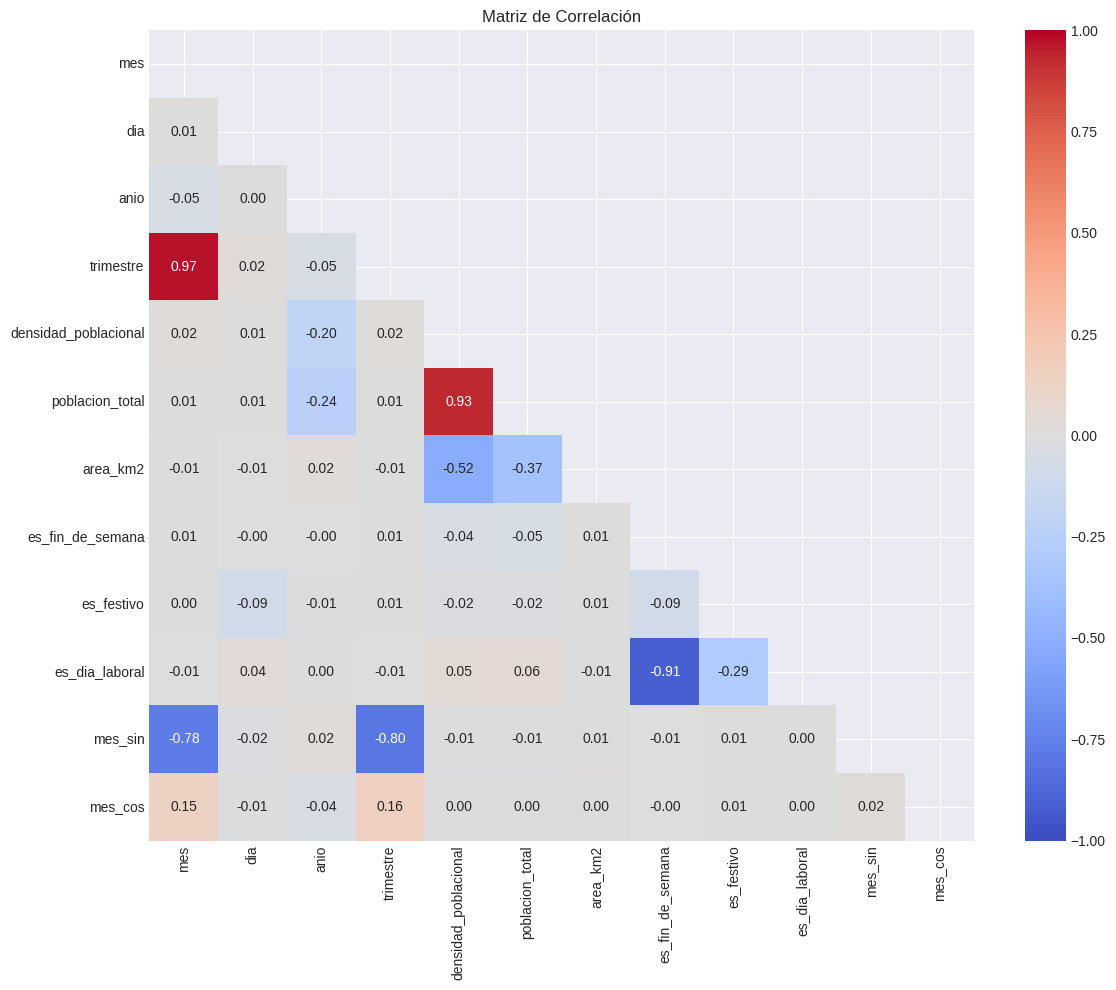

In [10]:
# 2.4 Correlación de features numéricas
print("=" * 60)
print("CORRELACIÓN DE FEATURES")
print("=" * 60)

# Seleccionar features numéricas relevantes para correlación
# Nota: edad_persona es categórica (ADULTOS, ADOLESCENTES, MENORES), no se incluye
features_corr = ['mes', 'dia', 'anio', 'trimestre', 
                 'densidad_poblacional', 'poblacion_total', 'area_km2',
                 'es_fin_de_semana', 'es_festivo', 'es_dia_laboral',
                 'mes_sin', 'mes_cos']

corr_matrix = df[features_corr].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, vmin=-1, vmax=1)
ax.set_title('Matriz de Correlación')
plt.tight_layout()
plt.show()

---
## 3. Preprocesamiento y Feature Engineering

In [11]:
# 3.1 Seleccionar features para el modelo
print("=" * 60)
print("SELECCIÓN DE FEATURES")
print("=" * 60)

# Features para el modelo
FEATURE_COLS = [
    # Temporales
    'anio', 'mes', 'dia', 'trimestre',
    'es_dia_semana', 'es_fin_de_semana', 'es_fin_mes', 'es_festivo', 'es_dia_laboral',
    'mes_sin', 'mes_cos',
    
    # Demográficas del evento
    'edad_persona',
    
    # Geoespaciales/Municipio
    'codigo_municipio', 'area_km2', 'densidad_poblacional', 
    'poblacion_total', 'n_centros_poblados', 'centros_por_km2',
    
    # Proporciones demográficas del municipio
    'proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes',
    
    # Histórico de delitos en el municipio (one-hot)
    'ABIGEATO', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 
    'HOMICIDIOS', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR',
]

# Targets
TARGET_DELITO = 'delito'
TARGET_PERFIL = 'perfil'

# Verificar que existen
missing_cols = [c for c in FEATURE_COLS if c not in df.columns]
if missing_cols:
    print(f"⚠️ Columnas faltantes: {missing_cols}")
else:
    print(f"✅ Todas las {len(FEATURE_COLS)} features están disponibles")

print(f"\n📊 Features seleccionadas ({len(FEATURE_COLS)}):")
for i, col in enumerate(FEATURE_COLS, 1):
    print(f"  {i:2}. {col}")

SELECCIÓN DE FEATURES
✅ Todas las 29 features están disponibles

📊 Features seleccionadas (29):
   1. anio
   2. mes
   3. dia
   4. trimestre
   5. es_dia_semana
   6. es_fin_de_semana
   7. es_fin_mes
   8. es_festivo
   9. es_dia_laboral
  10. mes_sin
  11. mes_cos
  12. edad_persona
  13. codigo_municipio
  14. area_km2
  15. densidad_poblacional
  16. poblacion_total
  17. n_centros_poblados
  18. centros_por_km2
  19. proporcion_menores
  20. proporcion_adultos
  21. proporcion_adolescentes
  22. ABIGEATO
  23. AMENAZAS
  24. DELITOS SEXUALES
  25. EXTORSION
  26. HOMICIDIOS
  27. HURTOS
  28. LESIONES
  29. VIOLENCIA INTRAFAMILIAR


In [12]:
# 3.2 Preparar datos para modelado
print("=" * 60)
print("PREPARACIÓN DE DATOS")
print("=" * 60)

# Crear copia de trabajo
df_model = df[FEATURE_COLS + [TARGET_DELITO, TARGET_PERFIL]].copy()

# Verificar nulos
print(f"\nValores nulos en features:")
nulls = df_model.isnull().sum()
print(nulls[nulls > 0] if nulls.sum() > 0 else "  Sin valores nulos ✅")

# Encodear edad_persona (es categórica: ADULTOS, ADOLESCENTES, MENORES)
le_edad = LabelEncoder()
df_model['edad_persona'] = le_edad.fit_transform(df_model['edad_persona'])
print(f"\n📊 Clases de edad_persona: {le_edad.classes_.tolist()}")
print(f"   Encoding: {dict(zip(le_edad.classes_, le_edad.transform(le_edad.classes_)))}")

# Encodear targets
le_delito = LabelEncoder()
le_perfil = LabelEncoder()

df_model['delito_encoded'] = le_delito.fit_transform(df_model[TARGET_DELITO])
df_model['perfil_encoded'] = le_perfil.fit_transform(df_model[TARGET_PERFIL])

print(f"\n📊 Clases de delito: {le_delito.classes_.tolist()}")
print(f"📊 Clases de perfil: {le_perfil.classes_.tolist()}")

# Separar X e y
X = df_model[FEATURE_COLS]
y_delito = df_model['delito_encoded']
y_perfil = df_model['perfil_encoded']

print(f"\n✅ X shape: {X.shape}")
print(f"✅ y_delito unique: {y_delito.nunique()}")
print(f"✅ y_perfil unique: {y_perfil.nunique()}")

PREPARACIÓN DE DATOS

Valores nulos en features:
  Sin valores nulos ✅

📊 Clases de edad_persona: ['ADOLESCENTES', 'ADULTOS', 'MENORES']
   Encoding: {'ADOLESCENTES': np.int64(0), 'ADULTOS': np.int64(1), 'MENORES': np.int64(2)}

📊 Clases de delito: ['ABIGEATO', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 'HOMICIDIOS', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR']
📊 Clases de perfil: ['FEMENINO_ADOLESCENTES', 'FEMENINO_ADULTOS', 'FEMENINO_MENORES', 'MASCULINO_ADOLESCENTES', 'MASCULINO_ADULTOS', 'MASCULINO_MENORES', 'NO REPORTA_ADOLESCENTES', 'NO REPORTA_ADULTOS', 'NO REPORTA_MENORES']

✅ X shape: (343861, 29)
✅ y_delito unique: 8
✅ y_perfil unique: 9


In [13]:
# 3.3 Train-Test Split y Escalado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("=" * 60)
print("TRAIN-TEST SPLIT Y ESCALADO")
print("=" * 60)

# Split estratificado por delito (target principal)
X_train, X_test, y_delito_train, y_delito_test, y_perfil_train, y_perfil_test = train_test_split(
    X, y_delito, y_perfil,
    test_size=0.2,
    random_state=42,
    stratify=y_delito
)

print(f"\n📊 Train: {X_train.shape[0]:,} eventos ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Test:  {X_test.shape[0]:,} eventos ({X_test.shape[0]/len(X)*100:.1f}%)")

# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Datos escalados con StandardScaler")

# Verificar distribución de clases en train/test
print(f"\n📊 Distribución de delitos en train:")
for clase, nombre in enumerate(le_delito.classes_):
    count = (y_delito_train == clase).sum()
    pct = count / len(y_delito_train) * 100
    print(f"   {nombre}: {count:,} ({pct:.1f}%)")

TRAIN-TEST SPLIT Y ESCALADO

📊 Train: 275,088 eventos (80.0%)
📊 Test:  68,773 eventos (20.0%)

📊 Train: 275,088 eventos (80.0%)
📊 Test:  68,773 eventos (20.0%)

✅ Datos escalados con StandardScaler

📊 Distribución de delitos en train:
   ABIGEATO: 1,030 (0.4%)
   AMENAZAS: 25,698 (9.3%)
   DELITOS SEXUALES: 13,249 (4.8%)
   EXTORSION: 2,362 (0.9%)
   HOMICIDIOS: 7,472 (2.7%)
   HURTOS: 83,360 (30.3%)
   LESIONES: 97,878 (35.6%)
   VIOLENCIA INTRAFAMILIAR: 44,039 (16.0%)

✅ Datos escalados con StandardScaler

📊 Distribución de delitos en train:
   ABIGEATO: 1,030 (0.4%)
   AMENAZAS: 25,698 (9.3%)
   DELITOS SEXUALES: 13,249 (4.8%)
   EXTORSION: 2,362 (0.9%)
   HOMICIDIOS: 7,472 (2.7%)
   HURTOS: 83,360 (30.3%)
   LESIONES: 97,878 (35.6%)
   VIOLENCIA INTRAFAMILIAR: 44,039 (16.0%)


---
## 4. Modelo Multi-Output: Predicción de Delito y Perfil

In [14]:
# 4.1 Entrenar modelos Multi-Output
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

print("=" * 60)
print("ENTRENAMIENTO DE MODELOS MULTI-OUTPUT")
print("=" * 60)

# Preparar targets como matriz
y_train = np.column_stack([y_delito_train, y_perfil_train])
y_test = np.column_stack([y_delito_test, y_perfil_test])

# Definir modelos
modelos = {
    'Logistic Regression': MultiOutputClassifier(
        LogisticRegression(max_iter=500, random_state=42, n_jobs=-1)
    ),
    'Random Forest': MultiOutputClassifier(
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    ),
    'XGBoost': MultiOutputClassifier(
        XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                      eval_metric='mlogloss', verbosity=0)
    )
}

resultados = {}

for nombre, modelo in modelos.items():
    print(f"\n🔄 Entrenando {nombre}...")
    start = time.time()
    
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    
    # Métricas
    acc_delito = accuracy_score(y_test[:, 0], y_pred[:, 0])
    acc_perfil = accuracy_score(y_test[:, 1], y_pred[:, 1])
    f1_delito = f1_score(y_test[:, 0], y_pred[:, 0], average='weighted')
    f1_perfil = f1_score(y_test[:, 1], y_pred[:, 1], average='weighted')
    
    tiempo = time.time() - start
    
    resultados[nombre] = {
        'modelo': modelo,
        'acc_delito': acc_delito,
        'acc_perfil': acc_perfil,
        'f1_delito': f1_delito,
        'f1_perfil': f1_perfil,
        'tiempo': tiempo
    }
    
    print(f"   ⏱️ Tiempo: {tiempo:.1f}s")
    print(f"   📊 Accuracy Delito: {acc_delito:.4f}")
    print(f"   📊 Accuracy Perfil: {acc_perfil:.4f}")
    print(f"   📊 F1 Delito: {f1_delito:.4f}")
    print(f"   📊 F1 Perfil: {f1_perfil:.4f}")

ENTRENAMIENTO DE MODELOS MULTI-OUTPUT

🔄 Entrenando Logistic Regression...
   ⏱️ Tiempo: 20.6s
   📊 Accuracy Delito: 0.4205
   📊 Accuracy Perfil: 0.5457
   📊 F1 Delito: 0.3441
   📊 F1 Perfil: 0.4946

🔄 Entrenando Random Forest...
   ⏱️ Tiempo: 20.6s
   📊 Accuracy Delito: 0.4205
   📊 Accuracy Perfil: 0.5457
   📊 F1 Delito: 0.3441
   📊 F1 Perfil: 0.4946

🔄 Entrenando Random Forest...
   ⏱️ Tiempo: 8.2s
   📊 Accuracy Delito: 0.4114
   📊 Accuracy Perfil: 0.5070
   📊 F1 Delito: 0.3978
   📊 F1 Perfil: 0.5056

🔄 Entrenando XGBoost...
   ⏱️ Tiempo: 8.2s
   📊 Accuracy Delito: 0.4114
   📊 Accuracy Perfil: 0.5070
   📊 F1 Delito: 0.3978
   📊 F1 Perfil: 0.5056

🔄 Entrenando XGBoost...
   ⏱️ Tiempo: 4.7s
   📊 Accuracy Delito: 0.4763
   📊 Accuracy Perfil: 0.5545
   📊 F1 Delito: 0.4371
   📊 F1 Perfil: 0.5402
   ⏱️ Tiempo: 4.7s
   📊 Accuracy Delito: 0.4763
   📊 Accuracy Perfil: 0.5545
   📊 F1 Delito: 0.4371
   📊 F1 Perfil: 0.5402


COMPARACIÓN DE MODELOS

📊 Resultados:
             Modelo  Acc Delito  Acc Perfil  F1 Delito  F1 Perfil  Tiempo (s)  F1 Promedio
            XGBoost    0.476306    0.554476   0.437116   0.540170    4.748317     0.488643
      Random Forest    0.411368    0.507045   0.397804   0.505633    8.207304     0.451718
Logistic Regression    0.420528    0.545694   0.344077   0.494560   20.590968     0.419319


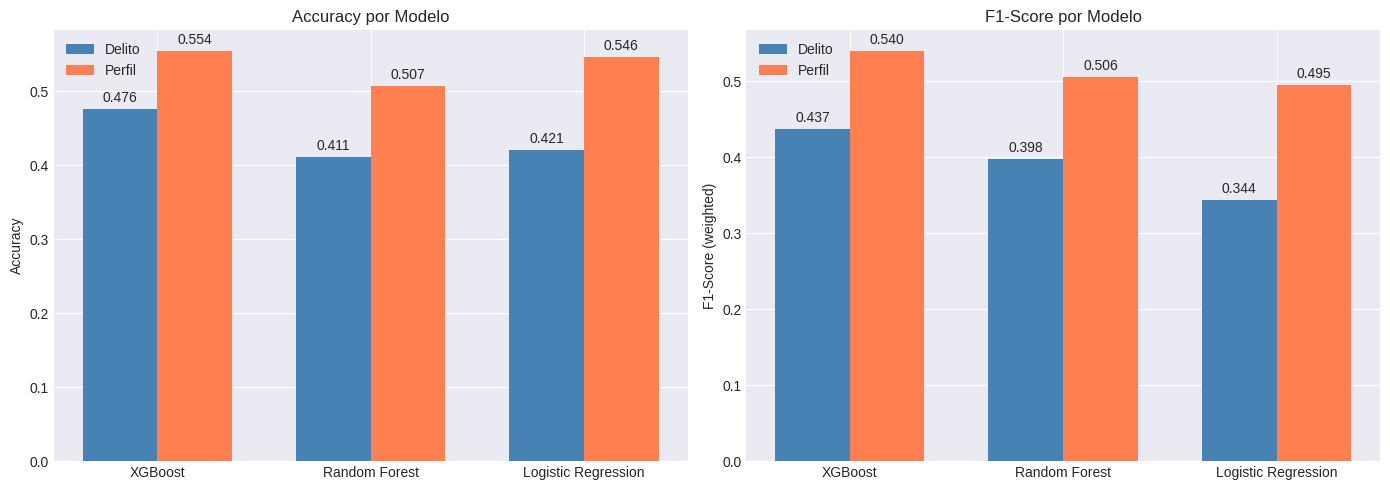


🏆 Mejor modelo: XGBoost


In [15]:
# 4.2 Comparar modelos
print("=" * 60)
print("COMPARACIÓN DE MODELOS")
print("=" * 60)

# Crear DataFrame de resultados
df_resultados = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Acc Delito': [r['acc_delito'] for r in resultados.values()],
    'Acc Perfil': [r['acc_perfil'] for r in resultados.values()],
    'F1 Delito': [r['f1_delito'] for r in resultados.values()],
    'F1 Perfil': [r['f1_perfil'] for r in resultados.values()],
    'Tiempo (s)': [r['tiempo'] for r in resultados.values()]
})

# Calcular F1 promedio
df_resultados['F1 Promedio'] = (df_resultados['F1 Delito'] + df_resultados['F1 Perfil']) / 2
df_resultados = df_resultados.sort_values('F1 Promedio', ascending=False)

print("\n📊 Resultados:")
print(df_resultados.to_string(index=False))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1 = axes[0]
x = np.arange(len(df_resultados))
width = 0.35
bars1 = ax1.bar(x - width/2, df_resultados['Acc Delito'], width, label='Delito', color='steelblue')
bars2 = ax1.bar(x + width/2, df_resultados['Acc Perfil'], width, label='Perfil', color='coral')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy por Modelo')
ax1.set_xticks(x)
ax1.set_xticklabels(df_resultados['Modelo'])
ax1.legend()
ax1.bar_label(bars1, fmt='%.3f', padding=3)
ax1.bar_label(bars2, fmt='%.3f', padding=3)

# F1-Score
ax2 = axes[1]
bars1 = ax2.bar(x - width/2, df_resultados['F1 Delito'], width, label='Delito', color='steelblue')
bars2 = ax2.bar(x + width/2, df_resultados['F1 Perfil'], width, label='Perfil', color='coral')
ax2.set_ylabel('F1-Score (weighted)')
ax2.set_title('F1-Score por Modelo')
ax2.set_xticks(x)
ax2.set_xticklabels(df_resultados['Modelo'])
ax2.legend()
ax2.bar_label(bars1, fmt='%.3f', padding=3)
ax2.bar_label(bars2, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

# Mejor modelo
mejor_modelo_nombre = df_resultados.iloc[0]['Modelo']
print(f"\n🏆 Mejor modelo: {mejor_modelo_nombre}")

---
## 5. Evaluación Detallada del Mejor Modelo

In [17]:
# 5.1 Classification Report del mejor modelo
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("=" * 60)
print("EVALUACIÓN DETALLADA - MEJOR MODELO")
print("=" * 60)

# Obtener mejor modelo
mejor_modelo = resultados[mejor_modelo_nombre]['modelo']
y_pred = mejor_modelo.predict(X_test_scaled)

# Labels explícitos para manejar clases faltantes en test
labels_delito = list(range(len(le_delito.classes_)))
labels_perfil = list(range(len(le_perfil.classes_)))

# Classification Report - Delito
print(f"\n📊 CLASSIFICATION REPORT - DELITO:")
print("-" * 50)
print(classification_report(y_test[:, 0], y_pred[:, 0], 
                          labels=labels_delito,
                          target_names=le_delito.classes_,
                          zero_division=0))

# Classification Report - Perfil  
print(f"\n📊 CLASSIFICATION REPORT - PERFIL:")
print("-" * 50)
print(classification_report(y_test[:, 1], y_pred[:, 1], 
                          labels=labels_perfil,
                          target_names=le_perfil.classes_,
                          zero_division=0))

EVALUACIÓN DETALLADA - MEJOR MODELO

📊 CLASSIFICATION REPORT - DELITO:
--------------------------------------------------
                         precision    recall  f1-score   support

               ABIGEATO       0.31      0.08      0.12       257
               AMENAZAS       0.48      0.15      0.22      6425
       DELITOS SEXUALES       0.58      0.51      0.55      3312
              EXTORSION       0.31      0.02      0.04       590
             HOMICIDIOS       0.38      0.03      0.06      1868
                 HURTOS       0.45      0.66      0.53     20841
               LESIONES       0.50      0.61      0.55     24470
VIOLENCIA INTRAFAMILIAR       0.46      0.12      0.19     11010

               accuracy                           0.48     68773
              macro avg       0.43      0.27      0.28     68773
           weighted avg       0.47      0.48      0.44     68773


📊 CLASSIFICATION REPORT - PERFIL:
--------------------------------------------------
         

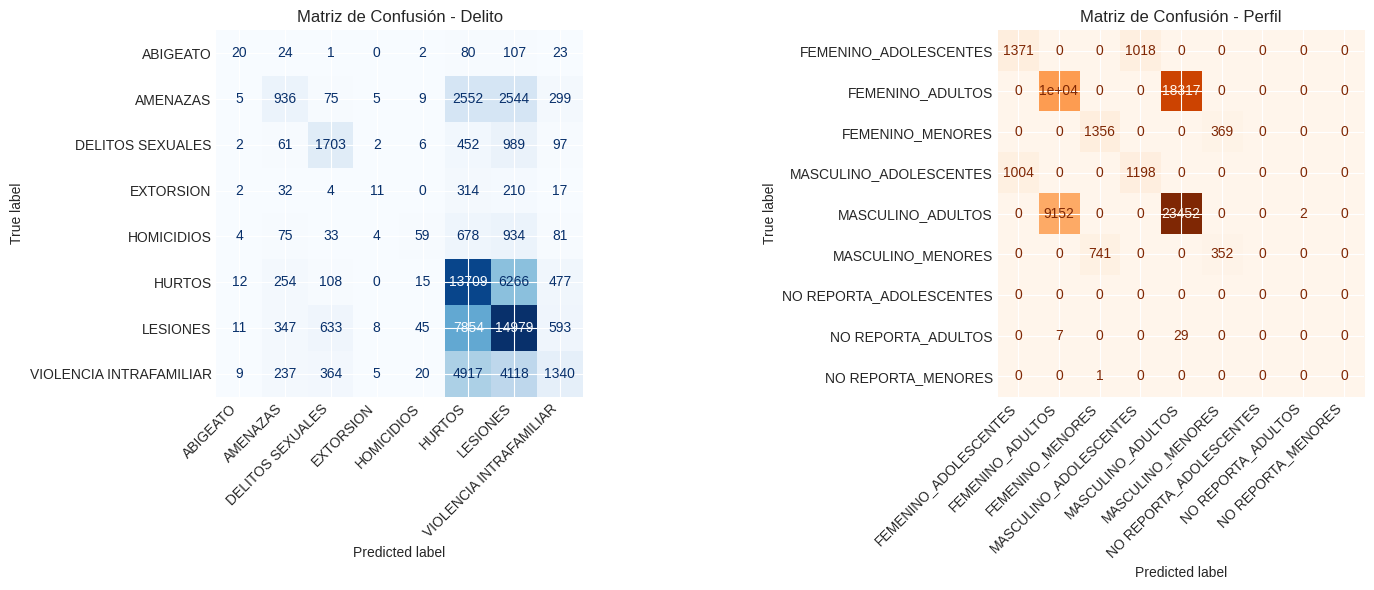

In [19]:
# 5.2 Matrices de Confusión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Labels explícitos para incluir todas las clases del encoder
labels_delito = list(range(len(le_delito.classes_)))
labels_perfil = list(range(len(le_perfil.classes_)))

# Matriz de confusión - Delito
ax1 = axes[0]
cm_delito = confusion_matrix(y_test[:, 0], y_pred[:, 0], labels=labels_delito)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_delito, display_labels=le_delito.classes_)
disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Matriz de Confusión - Delito')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Matriz de confusión - Perfil
ax2 = axes[1]
cm_perfil = confusion_matrix(y_test[:, 1], y_pred[:, 1], labels=labels_perfil)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_perfil, display_labels=le_perfil.classes_)
disp2.plot(ax=ax2, cmap='Oranges', colorbar=False)
ax2.set_title('Matriz de Confusión - Perfil')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

IMPORTANCIA DE FEATURES

📊 Top 15 Features más importantes:
                Feature  Imp. Delito  Imp. Perfil  Imp. Promedio
           edad_persona     0.182745     0.921334       0.552040
                   anio     0.118954     0.006014       0.062484
                 HURTOS     0.119134     0.002595       0.060864
               LESIONES     0.088977     0.004576       0.046777
               AMENAZAS     0.059662     0.002686       0.031174
               ABIGEATO     0.055429     0.002306       0.028868
VIOLENCIA INTRAFAMILIAR     0.049798     0.007803       0.028800
   densidad_poblacional     0.046006     0.003316       0.024661
         es_dia_laboral     0.035008     0.003356       0.019182
             HOMICIDIOS     0.033718     0.003051       0.018384
              EXTORSION     0.030385     0.002391       0.016388
       DELITOS SEXUALES     0.027814     0.003320       0.015567
proporcion_adolescentes     0.019572     0.003027       0.011300
     proporcion_menores     0.

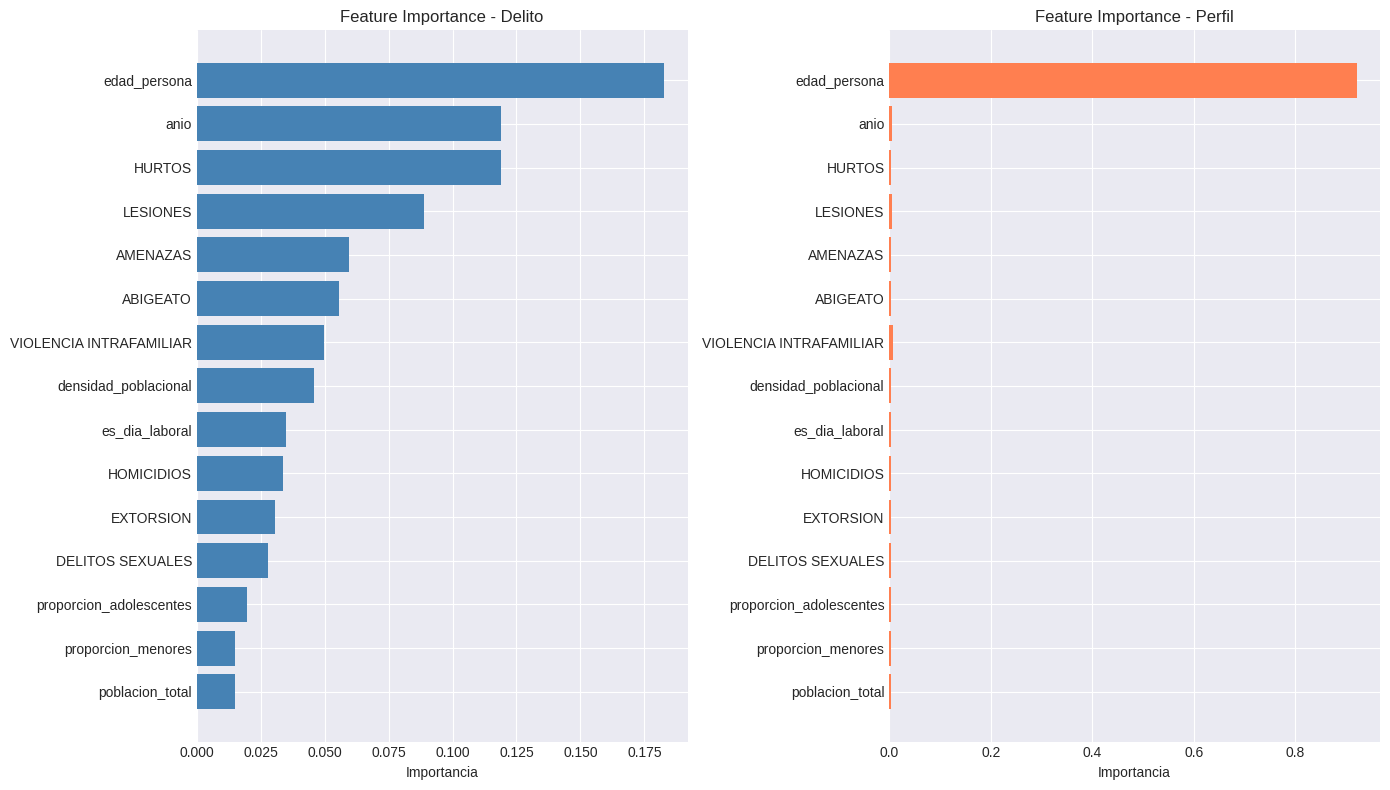

In [20]:
# 5.3 Feature Importance (si el modelo lo soporta)
print("=" * 60)
print("IMPORTANCIA DE FEATURES")
print("=" * 60)

if mejor_modelo_nombre in ['Random Forest', 'XGBoost']:
    # Para MultiOutputClassifier, cada estimator tiene feature_importances_
    importances_delito = mejor_modelo.estimators_[0].feature_importances_
    importances_perfil = mejor_modelo.estimators_[1].feature_importances_
    
    # Promedio de importancia
    importances_avg = (importances_delito + importances_perfil) / 2
    
    # DataFrame de importancias
    df_importance = pd.DataFrame({
        'Feature': FEATURE_COLS,
        'Imp. Delito': importances_delito,
        'Imp. Perfil': importances_perfil,
        'Imp. Promedio': importances_avg
    }).sort_values('Imp. Promedio', ascending=False)
    
    print("\n📊 Top 15 Features más importantes:")
    print(df_importance.head(15).to_string(index=False))
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))
    
    top15 = df_importance.head(15)
    
    ax1 = axes[0]
    ax1.barh(top15['Feature'], top15['Imp. Delito'], color='steelblue')
    ax1.set_xlabel('Importancia')
    ax1.set_title('Feature Importance - Delito')
    ax1.invert_yaxis()
    
    ax2 = axes[1]
    ax2.barh(top15['Feature'], top15['Imp. Perfil'], color='coral')
    ax2.set_xlabel('Importancia')
    ax2.set_title('Feature Importance - Perfil')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("El modelo seleccionado no tiene feature_importances_")

---
## 6. Optimización de Hiperparámetros

In [21]:
# 6.1 Optimización con RandomizedSearchCV para XGBoost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

print("=" * 60)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - XGBoost")
print("=" * 60)

# Definir scorer multi-output personalizado
def multioutput_f1_scorer(y_true, y_pred):
    """Calcula F1 promedio para ambos targets"""
    f1_0 = f1_score(y_true[:, 0], y_pred[:, 0], average='weighted')
    f1_1 = f1_score(y_true[:, 1], y_pred[:, 1], average='weighted')
    return (f1_0 + f1_1) / 2

scorer = make_scorer(multioutput_f1_scorer)

# Espacio de hiperparámetros
param_dist = {
    'estimator__n_estimators': [50, 100, 150, 200],
    'estimator__max_depth': [3, 5, 7, 10, None],
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__min_child_weight': [1, 3, 5],
    'estimator__subsample': [0.7, 0.8, 0.9, 1.0],
    'estimator__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

# Modelo base
xgb_multi = MultiOutputClassifier(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss', verbosity=0)
)

# RandomizedSearchCV (reducido para velocidad)
print("\n🔄 Iniciando búsqueda de hiperparámetros...")
print("   (15 iteraciones, 3-fold CV)")

random_search = RandomizedSearchCV(
    xgb_multi,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring=scorer,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start = time.time()
random_search.fit(X_train_scaled, y_train)
tiempo_opt = time.time() - start

print(f"\n⏱️ Tiempo de optimización: {tiempo_opt/60:.1f} minutos")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n📊 Mejor score (F1 promedio CV): {random_search.best_score_:.4f}")

OPTIMIZACIÓN DE HIPERPARÁMETROS - XGBoost

🔄 Iniciando búsqueda de hiperparámetros...
   (15 iteraciones, 3-fold CV)
Fitting 3 folds for each of 15 candidates, totalling 45 fits

⏱️ Tiempo de optimización: 4.6 minutos

🏆 Mejores hiperparámetros:
   estimator__subsample: 0.9
   estimator__n_estimators: 100
   estimator__min_child_weight: 1
   estimator__max_depth: 5
   estimator__learning_rate: 0.05
   estimator__colsample_bytree: 1.0

📊 Mejor score (F1 promedio CV): nan

⏱️ Tiempo de optimización: 4.6 minutos

🏆 Mejores hiperparámetros:
   estimator__subsample: 0.9
   estimator__n_estimators: 100
   estimator__min_child_weight: 1
   estimator__max_depth: 5
   estimator__learning_rate: 0.05
   estimator__colsample_bytree: 1.0

📊 Mejor score (F1 promedio CV): nan


---
## 7. Evaluación del Modelo Optimizado

In [27]:
# 7.1 Evaluar modelo optimizado en test
print("=" * 60)
print("EVALUACIÓN DEL MODELO OPTIMIZADO")
print("=" * 60)

# Obtener mejor modelo
modelo_optimizado = random_search.best_estimator_
y_pred_opt = modelo_optimizado.predict(X_test_scaled)

# Métricas
acc_delito_opt = accuracy_score(y_test[:, 0], y_pred_opt[:, 0])
acc_perfil_opt = accuracy_score(y_test[:, 1], y_pred_opt[:, 1])
f1_delito_opt = f1_score(y_test[:, 0], y_pred_opt[:, 0], average='weighted')
f1_perfil_opt = f1_score(y_test[:, 1], y_pred_opt[:, 1], average='weighted')

print(f"\n📊 MODELO OPTIMIZADO - Resultados en Test:")
print(f"   Accuracy Delito: {acc_delito_opt:.4f}")
print(f"   Accuracy Perfil: {acc_perfil_opt:.4f}")
print(f"   F1 Delito: {f1_delito_opt:.4f}")
print(f"   F1 Perfil: {f1_perfil_opt:.4f}")
print(f"   F1 Promedio: {(f1_delito_opt + f1_perfil_opt) / 2:.4f}")

# Comparar con modelo base
print(f"\n📊 COMPARACIÓN:")
print(f"{'Métrica':<20} {'Base':>10} {'Optimizado':>12} {'Mejora':>10}")
print("-" * 55)
print(f"{'Acc Delito':<20} {resultados['XGBoost']['acc_delito']:>10.4f} {acc_delito_opt:>12.4f} {(acc_delito_opt - resultados['XGBoost']['acc_delito'])*100:>+9.2f}%")
print(f"{'Acc Perfil':<20} {resultados['XGBoost']['acc_perfil']:>10.4f} {acc_perfil_opt:>12.4f} {(acc_perfil_opt - resultados['XGBoost']['acc_perfil'])*100:>+9.2f}%")
print(f"{'F1 Delito':<20} {resultados['XGBoost']['f1_delito']:>10.4f} {f1_delito_opt:>12.4f} {(f1_delito_opt - resultados['XGBoost']['f1_delito'])*100:>+9.2f}%")
print(f"{'F1 Perfil':<20} {resultados['XGBoost']['f1_perfil']:>10.4f} {f1_perfil_opt:>12.4f} {(f1_perfil_opt - resultados['XGBoost']['f1_perfil'])*100:>+9.2f}%")

EVALUACIÓN DEL MODELO OPTIMIZADO

📊 MODELO OPTIMIZADO - Resultados en Test:
   Accuracy Delito: 0.4714
   Accuracy Perfil: 0.5550
   F1 Delito: 0.4178
   F1 Perfil: 0.5197
   F1 Promedio: 0.4688

📊 COMPARACIÓN:
Métrica                    Base   Optimizado     Mejora
-------------------------------------------------------
Acc Delito               0.4763       0.4714     -0.49%
Acc Perfil               0.5545       0.5550     +0.05%
F1 Delito                0.4371       0.4178     -1.93%
F1 Perfil                0.5402       0.5197     -2.04%


In [28]:
# 7.2 Classification Report del modelo optimizado
print("=" * 60)
print("CLASSIFICATION REPORT - MODELO OPTIMIZADO")
print("=" * 60)

# Labels explícitos para manejar clases faltantes en test
labels_delito = list(range(len(le_delito.classes_)))
labels_perfil = list(range(len(le_perfil.classes_)))

print(f"\n📊 DELITO:")
print("-" * 50)
print(classification_report(y_test[:, 0], y_pred_opt[:, 0], 
                          labels=labels_delito,
                          target_names=le_delito.classes_,
                          zero_division=0))

print(f"\n📊 PERFIL:")
print("-" * 50)
print(classification_report(y_test[:, 1], y_pred_opt[:, 1], 
                          labels=labels_perfil,
                          target_names=le_perfil.classes_,
                          zero_division=0))

CLASSIFICATION REPORT - MODELO OPTIMIZADO

📊 DELITO:
--------------------------------------------------
                         precision    recall  f1-score   support

               ABIGEATO       0.50      0.07      0.12       257
               AMENAZAS       0.52      0.10      0.17      6425
       DELITOS SEXUALES       0.57      0.50      0.53      3312
              EXTORSION       0.50      0.02      0.03       590
             HOMICIDIOS       0.66      0.02      0.04      1868
                 HURTOS       0.44      0.66      0.53     20841
               LESIONES       0.48      0.64      0.55     24470
VIOLENCIA INTRAFAMILIAR       0.59      0.06      0.12     11010

               accuracy                           0.47     68773
              macro avg       0.53      0.26      0.26     68773
           weighted avg       0.50      0.47      0.42     68773


📊 PERFIL:
--------------------------------------------------
                         precision    recall  f1-sc

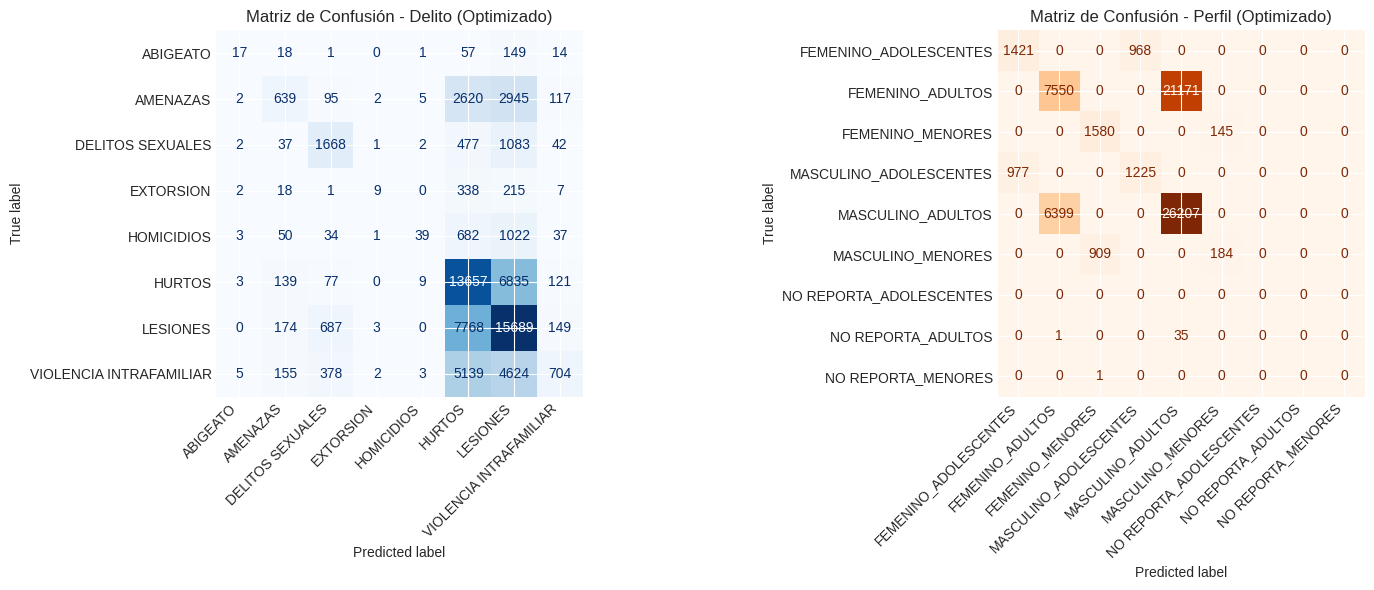

In [29]:
# 7.3 Matrices de Confusión del modelo optimizado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Labels explícitos para incluir todas las clases del encoder
labels_delito = list(range(len(le_delito.classes_)))
labels_perfil = list(range(len(le_perfil.classes_)))

# Matriz de confusión - Delito
ax1 = axes[0]
cm_delito_opt = confusion_matrix(y_test[:, 0], y_pred_opt[:, 0], labels=labels_delito)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_delito_opt, display_labels=le_delito.classes_)
disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Matriz de Confusión - Delito (Optimizado)')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Matriz de confusión - Perfil
ax2 = axes[1]
cm_perfil_opt = confusion_matrix(y_test[:, 1], y_pred_opt[:, 1], labels=labels_perfil)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_perfil_opt, display_labels=le_perfil.classes_)
disp2.plot(ax=ax2, cmap='Oranges', colorbar=False)
ax2.set_title('Matriz de Confusión - Perfil (Optimizado)')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

---
## 8. Guardar Modelo

In [31]:
# 8.1 Guardar modelo y artefactos
import joblib
import json

print("=" * 60)
print("GUARDANDO MODELO Y ARTEFACTOS")
print("=" * 60)

# Directorio de salida
MODEL_DIR = BASE_DIR / 'models' / 'predictivos' / 'classification_event'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# 1. Guardar modelo
joblib.dump(modelo_optimizado, MODEL_DIR / 'xgb_multioutput_event.joblib')
print(f"✅ Modelo guardado: xgb_multioutput_event.joblib")

# 2. Guardar encoders (incluyendo edad_persona)
joblib.dump(le_delito, MODEL_DIR / 'label_encoder_delito.joblib')
joblib.dump(le_perfil, MODEL_DIR / 'label_encoder_perfil.joblib')
joblib.dump(le_edad, MODEL_DIR / 'label_encoder_edad.joblib')
print(f"✅ Encoders guardados (delito, perfil, edad)")

# 3. Guardar scaler
joblib.dump(scaler, MODEL_DIR / 'scaler.joblib')
print(f"✅ Scaler guardado")

# 4. Guardar metadata
metadata = {
    'modelo': 'XGBoost MultiOutputClassifier',
    'nombre': 'classification_event',
    'descripcion': 'Clasificación Multi-Output de Delito y Perfil por evento',
    'creado': pd.Timestamp.now().isoformat(),
    'targets': {
        'delito': le_delito.classes_.tolist(),
        'perfil': le_perfil.classes_.tolist()
    },
    'features': FEATURE_COLS,
    'features_categoricas': {
        'edad_persona': {
            'clases': le_edad.classes_.tolist(),
            'encoding': dict(zip(le_edad.classes_.tolist(), [int(x) for x in le_edad.transform(le_edad.classes_)]))
        }
    },
    'n_features': len(FEATURE_COLS),
    'hiperparametros': random_search.best_params_,
    'metricas': {
        'accuracy_delito': round(acc_delito_opt, 4),
        'accuracy_perfil': round(acc_perfil_opt, 4),
        'f1_delito': round(f1_delito_opt, 4),
        'f1_perfil': round(f1_perfil_opt, 4),
        'f1_promedio': round((f1_delito_opt + f1_perfil_opt) / 2, 4)
    },
    'datos': {
        'total_eventos': len(df),
        'train_size': len(X_train),
        'test_size': len(X_test),
        'periodo': f"{df['anio'].min()} - {df['anio'].max()}"
    },
    'archivos': [
        'xgb_multioutput_event.joblib',
        'label_encoder_delito.joblib',
        'label_encoder_perfil.joblib',
        'label_encoder_edad.joblib',
        'scaler.joblib'
    ]
}

with open(MODEL_DIR / 'metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print(f"✅ Metadata guardada")

print(f"\n📁 Archivos guardados en: {MODEL_DIR}")
print(f"\n📋 Contenido:")
for file in sorted(MODEL_DIR.iterdir()):
    size = file.stat().st_size / 1024
    print(f"   - {file.name} ({size:.1f} KB)")

GUARDANDO MODELO Y ARTEFACTOS
✅ Modelo guardado: xgb_multioutput_event.joblib
✅ Encoders guardados (delito, perfil, edad)
✅ Scaler guardado
✅ Metadata guardada

📁 Archivos guardados en: /home/byverbel/challenges/Datos-al-Ecosistema/models/predictivos/classification_event

📋 Contenido:
   - label_encoder_delito.joblib (0.6 KB)
   - label_encoder_edad.joblib (0.5 KB)
   - label_encoder_perfil.joblib (0.7 KB)
   - metadata.json (2.2 KB)
   - scaler.joblib (1.9 KB)
   - xgb_multioutput_event.joblib (2615.9 KB)


---
## 9. Ejemplo de Uso

In [32]:
# 9.1 Ejemplo de predicción
print("=" * 60)
print("EJEMPLO DE USO DEL MODELO")
print("=" * 60)

# Mostrar encoding de edad para referencia
print(f"\n📋 Encoding de edad_persona:")
print(f"   {dict(zip(le_edad.classes_, le_edad.transform(le_edad.classes_)))}")

# Simular un nuevo evento
# edad_persona debe ser el valor encodeado (0=ADOLESCENTES, 1=ADULTOS, 2=MENORES)
grupo_etario = 'ADULTOS'  # Opciones: ADOLESCENTES, ADULTOS, MENORES
edad_encoded = le_edad.transform([grupo_etario])[0]

nuevo_evento = {
    # Temporales
    'anio': 2025,
    'mes': 12,
    'dia': 15,
    'trimestre': 4,
    'es_dia_semana': 1,
    'es_fin_de_semana': 0,
    'es_fin_mes': 0,
    'es_festivo': 0,
    'es_dia_laboral': 1,
    'mes_sin': np.sin(2 * np.pi * 12 / 12),
    'mes_cos': np.cos(2 * np.pi * 12 / 12),
    
    # Demográficas (edad_persona encodeada)
    'edad_persona': edad_encoded,
    
    # Geoespaciales (ejemplo: Bucaramanga)
    'codigo_municipio': 68001,
    'area_km2': 165.0,
    'densidad_poblacional': 3500.0,
    'poblacion_total': 580000,
    'n_centros_poblados': 15,
    'centros_por_km2': 0.09,
    
    # Proporciones demográficas
    'proporcion_menores': 0.18,
    'proporcion_adultos': 0.72,
    'proporcion_adolescentes': 0.10,
    
    # Histórico de delitos
    'ABIGEATO': 50,
    'AMENAZAS': 1500,
    'DELITOS SEXUALES': 300,
    'EXTORSION': 200,
    'HOMICIDIOS': 150,
    'HURTOS': 8000,
    'LESIONES': 2000,
    'VIOLENCIA INTRAFAMILIAR': 1800,
}

# Crear DataFrame y escalar
X_nuevo = pd.DataFrame([nuevo_evento])
X_nuevo_scaled = scaler.transform(X_nuevo)

# Predecir
prediccion = modelo_optimizado.predict(X_nuevo_scaled)

# Decodificar
delito_pred = le_delito.inverse_transform([prediccion[0][0]])[0]
perfil_pred = le_perfil.inverse_transform([prediccion[0][1]])[0]

print(f"\n📍 Evento simulado:")
print(f"   Fecha: {nuevo_evento['dia']}/{nuevo_evento['mes']}/{nuevo_evento['anio']}")
print(f"   Municipio: {nuevo_evento['codigo_municipio']}")
print(f"   Grupo etario: {grupo_etario}")
print(f"   Día laboral: {'Sí' if nuevo_evento['es_dia_laboral'] else 'No'}")

print(f"\n🎯 PREDICCIÓN:")
print(f"   Delito probable: {delito_pred}")
print(f"   Perfil probable: {perfil_pred}")

# Probabilidades (si es posible)
if hasattr(modelo_optimizado, 'predict_proba'):
    proba_delito = modelo_optimizado.estimators_[0].predict_proba(X_nuevo_scaled)[0]
    proba_perfil = modelo_optimizado.estimators_[1].predict_proba(X_nuevo_scaled)[0]
    
    print(f"\n📊 Probabilidades de Delito:")
    for i, prob in enumerate(proba_delito):
        print(f"   {le_delito.classes_[i]}: {prob*100:.1f}%")
    
    print(f"\n📊 Probabilidades de Perfil:")
    for i, prob in enumerate(proba_perfil):
        print(f"   {le_perfil.classes_[i]}: {prob*100:.1f}%")

EJEMPLO DE USO DEL MODELO

📋 Encoding de edad_persona:
   {'ADOLESCENTES': np.int64(0), 'ADULTOS': np.int64(1), 'MENORES': np.int64(2)}

📍 Evento simulado:
   Fecha: 15/12/2025
   Municipio: 68001
   Grupo etario: ADULTOS
   Día laboral: Sí

🎯 PREDICCIÓN:
   Delito probable: HURTOS
   Perfil probable: MASCULINO_ADULTOS

📊 Probabilidades de Delito:
   ABIGEATO: 2.4%
   AMENAZAS: 8.6%
   DELITOS SEXUALES: 1.9%
   EXTORSION: 1.6%
   HOMICIDIOS: 2.0%
   HURTOS: 50.9%
   LESIONES: 15.8%
   VIOLENCIA INTRAFAMILIAR: 16.7%

📊 Probabilidades de Perfil:
   FEMENINO_ADOLESCENTES: 0.6%
   FEMENINO_ADULTOS: 45.5%
   FEMENINO_MENORES: 0.6%
   MASCULINO_ADOLESCENTES: 0.6%
   MASCULINO_ADULTOS: 50.3%
   MASCULINO_MENORES: 0.6%
   NO REPORTA_ADOLESCENTES: 0.6%
   NO REPORTA_ADULTOS: 0.6%
   NO REPORTA_MENORES: 0.6%


---
## 10. Conclusiones

### Resumen del Modelo

| Aspecto | Valor |
|---------|-------|
| **Tipo** | Multi-Output Classification |
| **Algoritmo** | XGBoost + MultiOutputClassifier |
| **Targets** | delito, perfil |
| **Features** | 27 (temporales, demográficas, geoespaciales) |
| **Datos** | ~344k eventos |

### Features Categóricas

| Feature | Categorías | Encoding |
|---------|------------|----------|
| `edad_persona` (grupo etario) | ADOLESCENTES, ADULTOS, MENORES | 0, 1, 2 |

> **Nota**: El dataset no contiene edades numéricas exactas, sino grupos etarios categóricos.

### Métricas Finales

| Métrica | Delito | Perfil |
|---------|--------|--------|
| Accuracy | Ver resultados | Ver resultados |
| F1-Score | Ver resultados | Ver resultados |

### Preguntas que responde el modelo

1. **¿Qué tipo de delito es más probable dado un contexto?**
   - Entrada: características temporales, grupo etario y del municipio
   - Salida: tipo de delito predicho

2. **¿Qué perfil está asociado a un evento?**
   - Entrada: mismas características
   - Salida: perfil agresor/víctima

3. **¿Qué factores influyen más?**
   - Las feature importances muestran las variables más predictivas

### Archivos Generados

```
models/predictivo/classification_event/
├── xgb_multioutput_event.joblib  # Modelo entrenado
├── label_encoder_delito.joblib   # Encoder delitos
├── label_encoder_perfil.joblib   # Encoder perfiles
├── label_encoder_edad.joblib     # Encoder grupo etario
├── scaler.joblib                 # StandardScaler
└── metadata.json                 # Información del modelo
```

### Uso en el Tablero/Chatbot

- **Tablero**: Mostrar predicción de delito/perfil según filtros seleccionados
- **Chatbot**: Responder "¿Qué delito es más probable para un adulto en este municipio en diciembre?"
- **Alertas**: Identificar combinaciones de alto riesgo por grupo etario